# Building a bulk system

Let's build a Fe bulk with BCC structure using a python script.

Import the required libraries

* [numpy](http://www.numpy.org/) handles numeric arrays and mathematical operations.
* [product](https://docs.python.org/3.7/library/itertools.html#itertools.product) returns cartesian product of input iterables.
* [matplotlib](https://matplotlib.org/) produces figures.
* [defaultdict](https://docs.python.org/3.7/library/collections.html#collections.defaultdict) is a dictionary where each *value* has a defined type.
* [Axes3D](https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html) produces 3D graphics using matplotlib.

In [1]:
import numpy
from itertools import product
from matplotlib import pyplot
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D

Define the edge length of the bulk (```L```) measured in magnetic unit cells (muc).

In [2]:
L = 5 # muc

Define the spin value (```spin```), its magnetic moment (```mu```), the anisotropy constant (```kan```) and the nearest neighbors exchange interaction (```jex```). These values were reported [elsewhere](http://iopscience.iop.org/article/10.1088/0953-8984/26/10/103202/meta). In order to use coherent units, ```kan``` and ```jex``` are given both in units of energy (meV), while ```mu``` is given in units of energy/magnetic field (meV/T). Then, the Boltzmann constant must be given in units of energy/temperature (meV/K) in the JSON input file. Finally, define the [spin update policy](https://pcm-ca.github.io/vegas/spin-update-policies/) for the direction of the magnetic moments.

In [3]:
mub =  5.788e-2 # meV/T

In [4]:
spin = 1.0
mu = 2.22 * mub
kan = 3.53e-3 # meV/atom
jex = 44.01 # meV/link
update_policy = "adaptive"

Create a list of sites.

In [5]:
sites = list()
for site in product(range(0, L), range(0, L), range(0, L)):
    sites.append(site)
    
    x, y, z = site
    sites.append((x + 0.5, y + 0.5, z + 0.5))

Convert the previous list to numpy arrays.

In [6]:
positions = numpy.array(sites)

Generate a 3D graphic of the Fe bulk.

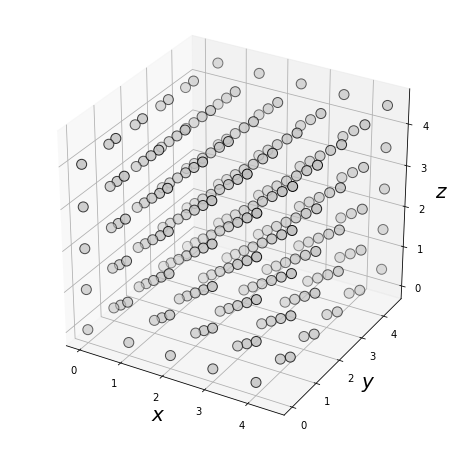

In [7]:
fig = pyplot.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2],
           s=100, color="silver", edgecolor="black")
ax.grid()
ax.set_xlabel(r"$x$", fontsize=20)
ax.set_ylabel(r"$y$", fontsize=20)
ax.set_zlabel(r"$z$", fontsize=20)
pyplot.show()

Generate graphics of $xy$, $xz$ and $yz$ plane cross-sections to better visualize the BBC structure.

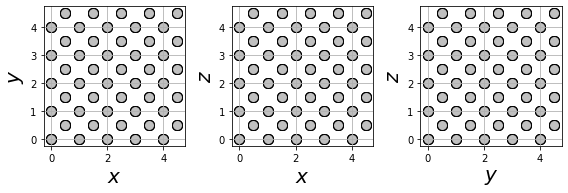

In [8]:
fig = pyplot.figure(figsize=(8, 8))

ax1 = fig.add_subplot(131)
ax1.scatter(positions[:, 0], positions[:, 1],
           s=100, color="silver", edgecolor="black")
ax1.grid()
ax1.set_xlabel(r"$x$", fontsize=20)
ax1.set_ylabel(r"$y$", fontsize=20)
ax1.set_aspect("equal")

ax2 = fig.add_subplot(132)
ax2.scatter(positions[:, 0], positions[:, 2],
           s=100, color="silver", edgecolor="black")
ax2.grid()
ax2.set_xlabel(r"$x$", fontsize=20)
ax2.set_ylabel(r"$z$", fontsize=20)
ax2.set_aspect("equal")


ax3 = fig.add_subplot(133)
ax3.scatter(positions[:, 1], positions[:, 2],
           s=100, color="silver", edgecolor="black")
ax3.grid()
ax3.set_xlabel(r"$y$", fontsize=20)
ax3.set_ylabel(r"$z$", fontsize=20)
ax3.set_aspect("equal")

pyplot.tight_layout()
pyplot.show()

Identify the neighbors of each magnetic moment and store them in a dictionary. Periodic boundary conditions are established.

In [9]:
nhbs = defaultdict(list)
for site in sites:
    x, y, z = site
    for dx, dy, dz in [(0.5, 0.5, 0.5),
                       (0.5, 0.5, -0.5),
                       (0.5, -0.5, 0.5),
                       (0.5, -0.5, -0.5),
                       (-0.5, 0.5, 0.5),
                       (-0.5, 0.5, -0.5),
                       (-0.5, -0.5, 0.5),
                       (-0.5, -0.5, -0.5)]:
        nhb = ((x + dx) % L, (y + dy) % L, (z + dz) % L)
        if nhb in sites:
            nhbs[site].append(nhb)

Make some verifications: that each site has $8$ neighbors, that the neighbors of each site are $\dfrac{\sqrt{3}}{2}$ muc away, and that each site is in the neighbors list of each of its neighbors. If two sites are neighbors because of the periodic boundary conditions, they are not $\dfrac{\sqrt{3}}{2}$ muc away. However, one of the $27$ replicas must be this distance away.

In [10]:
for site in sites:
    assert len(nhbs[site]) == 8
    for nhb in nhbs[site]:
        assert site in nhbs[nhb]
        
        dists = list()
        for x in [-L, 0, L]:
            for y in [-L, 0, L]:
                for z in [-L, 0, L]:
                    dists.append(numpy.linalg.norm(numpy.array(site) + (x, y, z) - numpy.array(nhb)))
        assert (27 - numpy.count_nonzero(numpy.array(dists) - (numpy.sqrt(3)/2)) == 1)

Create a dictionary to identify the type of each site, which in this case is Fe for all.

In [11]:
types = dict()
for site in sites:
    types[site] = "Fe"

Define the anisotropy axes. It is enough to just define two axes, the third one is computed to produce cubic anisotropy.  Also, define the direction of the external magnetic field for each site, which in this case is the $+z$ direction for all the ions. The external magnetic field is multiplied by the magnetic moment of Fe. Then, the magnetic field values in the JSON input file must be given in Teslas.

In [12]:
anisotropy_axis = dict()
field_axis = dict()
for site in sites:
    anisotropy_axis[site] = [(1.0, 0.0, 0.0), (0.0, 1.0, 0.0)]
    field_axis[site] = (0.0, 0.0, mu)

Count the number of interactions equal to the sum of the neighbors of each site, and the number of sites as the length of the list of the sites.

In [13]:
num_interactions = 0
for site in sites:
    num_interactions += len(nhbs[site])
num_sites = len(sites)

Create the files to store the structural properties (```sample.dat```) and the anisotropy (```anisotropy.dat```) of the sample.

In [14]:
sample_file = open("sample.dat", mode="w")
anisotropy_file = open("anisotropy.dat", mode="w")

Write in the first line of ```sample_file``` the number of sites, interactions and types:

In [15]:
sample_file.write("{} {} {}\n".format(num_sites, num_interactions, len(set(types.values()))))
print(num_sites, num_interactions, len(set(types.values())))

250 2000 1


Write the ion types on a different line each one.

In [16]:
for t in sorted(set(types.values())):
    sample_file.write("{}\n".format(t))
    print(t)

Fe


Write the parameters of each site according to the established [format](/vegas/system-building/).

In [17]:
for site in sites:
    i = sites.index(site)
    t = types[site]
    sample_file.write("{} {} {} {} {} {} {} {} {} {}\n".format(
        i, *site, spin, *field_axis[site], t, update_policy))
    
    anisotropy_file.write("{} {} {} {} {} {} {}\n".format(
        *anisotropy_axis[site][0],
        *anisotropy_axis[site][1],
        kan))

Write the exchange interactions between every pair of neighbors.

In [18]:
for site in sites:
    t = types[site]
    for nhb in nhbs[site]:
        nhb_t = types[nhb]
        sample_file.write("{} {} {}\n".format(
            sites.index(site), sites.index(nhb), jex))

Close the files.

In [19]:
sample_file.close()
anisotropy_file.close()

The result of this script is the creation of two files: ```sample.dat``` and ```anisotropy.dat```, which store the structural properties and the anisotropy of the Fe bulk system.